In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121/torch_stable.html
!pip install --upgrade transformers accelerate peft
!pip install xformers
!pip install unsloth

Looking in indexes: https://download.pytorch.org/whl/cu121/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.56.2
    Uninstalling transformers-4.56.2:
      Successfully uninstalled transformers-4.56.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.5/317.5 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 503.6/503.6 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 564.7/564.7 kB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

In [2]:

from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import Dataset
import json
import os
import torch
import re
import html

max_seq_length = 2048
dtype = None
load_in_4bit = True

selectded_model = "unsloth/Phi-3-medium-4k-instruct"

fourbit_models = [selectded_model]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = selectded_model,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.9.11: Fast Mistral patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.71G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/194 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

chat_template.jinja:   0%|          | 0.00/318 [00:00<?, ?B/s]

Unsloth 2025.9.11 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


In [3]:


def solve_relative_path(file_path: str) -> str:
    project_root: str = os.path.dirname(os.getcwd())
    data_path: str = os.path.abspath(os.path.join(project_root, file_path))
    return data_path

def read_json_file(file_path: str) -> list[tuple[str, str]]:
    training_data = []

    with open(file_path, "r") as file:
        buffer: str = ""
        for line in file:
            buffer += line.strip()
            try:
                item: dict = json.loads(buffer)
                buffer = ""
                title: str = clean_text(item.get("title", ""))
                content: str = clean_text(item.get("content", ""))
                if title and content:
                    training_data.append((title, content))
            except json.JSONDecodeError:
                continue
    return training_data

def clean_text(text: str) -> str:
    text = html.unescape(text)
    text = re.sub(r"--.*", "", text)
    text = re.sub(r"[^\x00-\x7F]+", "", text)
    text = re.sub(r"\s+", " ", text)
    text = text.strip()

    return text

def verify_gpu_availability() -> None:
    is_cuda_available = torch.cuda.is_available()
    print(f"CUDA disponível? {is_cuda_available}")

    if is_cuda_available:
        gpu_count = torch.cuda.device_count()
        print(f"Número de GPUs disponíveis: {gpu_count}")
        for i in range(gpu_count):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

def format_data_for_training_with_phi35(data: list[tuple[str,str]]) -> list[str]:
    formatted_data = []
    for title, content in data:
        messages = [
            {"role": "user", "content": f"what is the minimum recommended age for reading {title} and why"},
            {"role": "assistant", "content": content},
        ]
        formatted_data.append({"text": tokenizer.apply_chat_template(messages, tokenize=False)})
    return formatted_data

def format_data_generator(file_path: str):
    with open(file_path, "r", encoding="utf-8") as f:
        buffer = ""
        for line in f:
            buffer += line.strip()
            try:
                item = json.loads(buffer)
                buffer = ""
                title = clean_text(item.get("title", ""))
                content = clean_text(item.get("content", ""))
                if title and content:
                    messages = [
                        {"role": "user", "content": f"what is the minimum recommended age for reading {title} and why"},
                        {"role": "assistant", "content": content},
                    ]
                    yield {"text": tokenizer.apply_chat_template(messages, tokenize=False)}
            except json.JSONDecodeError:
                continue

In [4]:
verify_gpu_availability()

dataset_path = solve_relative_path("/content/drive/MyDrive/Colab Notebooks/trn.json")
dataset = Dataset.from_generator(format_data_generator, gen_kwargs={"file_path": dataset_path})

training_args = TrainingArguments(
    output_dir="/home/thiagofernandes101/projects/fiap/FineTunningTechChallenge/results",
    per_device_train_batch_size=2,
    gradient_accumulation_steps=8,
    learning_rate=2e-4,
    max_steps=100,
    warmup_steps=5,
    logging_steps=1,
    eval_steps=200,
    save_steps=200,
    save_total_limit=1,
    optim="adamw_8bit",
    weight_decay=0.01,
    lr_scheduler_type="cosine",
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    report_to="none",
    seed=42,
    gradient_checkpointing=True,
)


trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    eval_dataset=dataset.select(range(200)),
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    args = training_args,
    packing = True,
)

print("Iniciando o fine-tuning...")
trainer_stats = trainer.train()
print("Fine-tuning concluído!")


CUDA disponível? True
Número de GPUs disponíveis: 1
GPU 0: Tesla T4


Generating train split: 0 examples [00:00, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/1389915 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=6):   0%|          | 0/200 [00:00<?, ? examples/s]

Iniciando o fine-tuning...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,389,915 | Num Epochs = 1 | Total steps = 100
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 65,536,000 of 14,025,774,080 (0.47% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,3.892000
2,3.192500
3,3.645800


Step,Training Loss
1,3.892000
2,3.192500
3,3.645800
4,3.013000
5,2.786100
6,2.553600
7,2.717100
8,2.404400
9,2.229400
10,2.109400


Fine-tuning concluído!


In [6]:
title_for_testing = "Jane's Battleships of the 20th Century"
message_for_testing = [
    {"role": "user", "content": f"what is the minimum recommended age for reading {title_for_testing} and why?"},
]
input_ids = tokenizer.apply_chat_template(message_for_testing, tokenize=True, add_generation_prompt=True, return_tensors="pt").to("cuda")
outputs = model.generate(input_ids=input_ids, max_new_tokens=256, use_cache=True)
results = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

print("\n--- TESTE DE INFERÊNCIA ---")
print(results)


--- TESTE DE INFERÊNCIA ---
what is the minimum recommended age for reading Jane's Battleships of the 20th Century and why? "Jane's Battleships of the 20th Century is a must for anyone interested in the history of the battleship. The book is well-illustrated and well-written, and the author's knowledge of the subject is evident. The book is a good reference for the history of the battleship, and it is a good read for anyone interested in the subject."


In [7]:
print("--- Overall Training Stats ---")
print(f"Total Steps Completed: {trainer_stats.global_step}")
print(f"Average Training Loss: {trainer_stats.training_loss:.4f}") # Format for readability

print("\n--- Detailed Log History ---")
# Access the detailed log from the trainer's state
log_history = trainer.state.log_history

for log in log_history:
    # We check if 'loss' is in the log, as the last entry might be the final training metrics
    if 'loss' in log:
        step = log['step']
        loss = log['loss']
        lr = log['learning_rate']
        print(f"Step: {step:<5} | Loss: {loss:.4f} | Learning Rate: {lr:.6f}")

--- Overall Training Stats ---
Total Steps Completed: 100
Average Training Loss: 2.1246

--- Detailed Log History ---
Step: 1     | Loss: 3.8920 | Learning Rate: 0.000000
Step: 2     | Loss: 3.1925 | Learning Rate: 0.000040
Step: 3     | Loss: 3.6458 | Learning Rate: 0.000080
Step: 4     | Loss: 3.0130 | Learning Rate: 0.000120
Step: 5     | Loss: 2.7861 | Learning Rate: 0.000160
Step: 6     | Loss: 2.5536 | Learning Rate: 0.000200
Step: 7     | Loss: 2.7171 | Learning Rate: 0.000200
Step: 8     | Loss: 2.4044 | Learning Rate: 0.000200
Step: 9     | Loss: 2.2294 | Learning Rate: 0.000200
Step: 10    | Loss: 2.1094 | Learning Rate: 0.000199
Step: 11    | Loss: 2.3931 | Learning Rate: 0.000199
Step: 12    | Loss: 2.1560 | Learning Rate: 0.000198
Step: 13    | Loss: 2.2067 | Learning Rate: 0.000197
Step: 14    | Loss: 2.0169 | Learning Rate: 0.000197
Step: 15    | Loss: 2.1464 | Learning Rate: 0.000196
Step: 16    | Loss: 2.1049 | Learning Rate: 0.000195
Step: 17    | Loss: 2.0227 | Learn

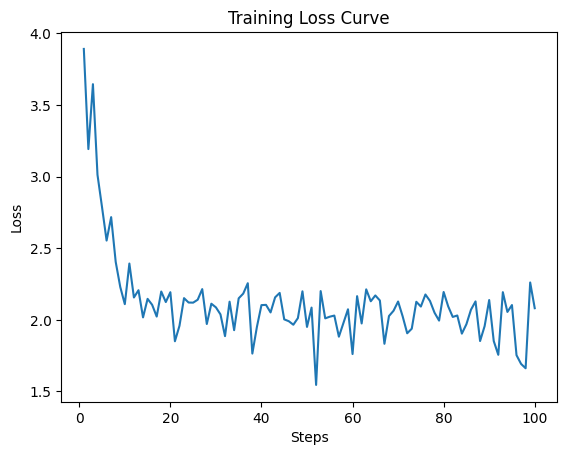

In [8]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(log_history)
df.dropna(subset=['loss'], inplace=True)
plt.plot(df['step'], df['loss'])
plt.title("Training Loss Curve")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.show()